### PyTorch Torchvision: COCO 8 Instance Segmentation

In [1]:
# import libraries
import io
import gc
import os
import cv2
import copy
import pickle
import shutil
import mlflow
import torch
import json
import torchvision
import numpy as np
import logging
from pathlib import Path
import pandas as pd
from collections import OrderedDict
from datetime import datetime
import torch
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
import torch.nn.functional as tnnf
from pycocotools.coco import COCO
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from mlflow.models import infer_signature
from typing import Any, Tuple, List, Dict
from torchvision import datasets
from torchvision.ops.boxes import box_convert
from torch.utils.data import DataLoader
from contextlib import redirect_stdout
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw
from torchvision.datasets import coco
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from numpy import uint8
import torch.nn.functional as F2
from torchvision.ops.boxes import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask_util
from torchvision.models.detection.roi_heads import fastrcnn_loss, maskrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

print(mlflow.__version__)
print(torchvision.__version__)

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

2.11.1
0.16.2+cu118


In [2]:
# set the logging level for 'mlflow' to DEBUG for detailed output.
logging.getLogger("mlflow").setLevel(logging.DEBUG)

In [3]:
# basic function usage
def collate_fn(batch):
    return tuple(zip(*batch))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols = len(imgs), squeeze = False)
    
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in mlflow.MlflowClient().list_artifacts(r.info.run_id, "model")]

    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

def get_iou_types(model):
    iou_types = ["bbox"]
    if isinstance(model, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

def coco_evaluate(imgs):
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim = 1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

def prepare_for_coco_segmentation(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        scores = prediction["scores"]
        labels = prediction["labels"]
        masks = prediction["masks"]

        masks = masks > 0.5

        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        rles = [
            mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype = np.uint8, order = "F"))[0] for mask in masks
        ]
        for rle in rles:
            rle["counts"] = rle["counts"].decode("utf-8")

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "segmentation": rle,
                    "score": scores[k],
                }
                for k, rle in enumerate(rles)
            ]
        )
    return coco_results

def coco_merge(img_ids, eval_imgs):
    all_img_ids = [img_ids]
    all_eval_imgs = [eval_imgs]

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index = True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs

def evaluation_forward(model, images, targets):
    original_image_sizes: List[Tuple[int, int]] = []

    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                bb_idx = torch.where(degenerate_boxes.any(dim = 1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                torch._assert(
                    False,
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}.",
                )

    features = model.backbone(images.tensors)

    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])

    model.rpn.training = True
    model.roi_heads.training = True

    # rpn
    features_rpn = list(features.values())

    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)

    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)

    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}

    assert targets is not None

    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)

    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )

    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    # roi_heads
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}

    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)

    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )

    if model.roi_heads.has_mask():
        mask_proposals = [p["boxes"] for p in result]

        if matched_idxs is None:
            raise ValueError("if in training, matched_idxs should not be None")

        num_images = len(proposals)
        mask_proposals = []
        pos_matched_idxs = []

        for img_id in range(num_images):
            pos = torch.where(labels[img_id] > 0)[0]
            mask_proposals.append(proposals[img_id][pos])
            pos_matched_idxs.append(matched_idxs[img_id][pos])

        if model.roi_heads.mask_roi_pool is not None:
            mask_features = model.roi_heads.mask_roi_pool(features, mask_proposals, image_shapes)
            mask_features = model.roi_heads.mask_head(mask_features)
            mask_logits = model.roi_heads.mask_predictor(mask_features)
        else:
            raise Exception("Expected mask_roi_pool to be not None")

        loss_mask = {}

        if targets is None or pos_matched_idxs is None or mask_logits is None:
            raise ValueError("targets, pos_matched_idxs, mask_logits cannot be None when training")

        gt_masks = [t["masks"] for t in targets]
        gt_labels = [t["labels"] for t in targets]
        rcnn_loss_mask = maskrcnn_loss(mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs)
        loss_mask = {"loss_mask": rcnn_loss_mask}

        detector_losses.update(loss_mask)

    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)

    model.rpn.training = False
    model.roi_heads.training = False

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)

    return losses, detections

def save_loss_curve(result: Dict[str, List[float]], dir_name: str):
    epochs = range(len(result['total_train_loss']))
    plt.figure(figsize = (15, 10))

    loss_types = ['total_train_loss', 'total_train_loss_classifier', 'total_train_loss_box_reg', 'total_train_loss_mask', 'total_train_loss_objectness', 'total_train_loss_rpn_box_reg']
    loss_titles = ['Loss', 'Loss Classifier', 'Loss Box Reg', 'Loss Mask', 'Loss Objectness', 'Loss RPN Box Reg']

    for i, loss_type in enumerate(loss_types):
        plt.subplot(2, 3, i + 1)
        plt.plot(epochs, result[loss_type], label = 'train')
        plt.plot(epochs, result['total_val_' + loss_type.split('_train_')[1]], label = 'val')
        plt.title(loss_titles[i])
        plt.xlabel('Epochs')
        plt.legend(loc = 'upper right')

    os.makedirs('result/' + dir_name, exist_ok = True)

    plt.savefig(f'result/{dir_name}/loss_plot.png')

    with open(f'result/{dir_name}/data.json', 'w') as f:
        json.dump(result, f)

    plt.close()

In [4]:
# custom dataset class
class InstanceSegmentation(datasets.CocoDetection):
    def __init__(self, root, annFile, transform):
        super(InstanceSegmentation, self).__init__(root, annFile, transform)
        self.coco = COCO(annFile)
        self.dataset = self.coco.dataset
        self.v2_transform = transform
        self.annFile = annFile

    def __getitem__(self, index) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # image, target = super(InstanceSegmentation, self).__getitem__(index)

        if self.v2_transform is not None:
            height, width = image.height, image.width
            original_bounding_box = torch.tensor([t['bbox'] for t in target])
            bounding_box_xyxy = box_convert(original_bounding_box, in_fmt = 'xywh', out_fmt = 'xyxy')
            tv_tensor_bounding_box_xyxy = tv_tensors.BoundingBoxes(bounding_box_xyxy, format = "XYXY", canvas_size = (height, width))
            label = torch.tensor([t['category_id'] for t in target])
            mask_np = np.array([self.coco.annToMask(t) for t in target])
            mask = torch.tensor(mask_np)
            # refer below link for more information
            # https://pytorch.org/blog/extending-torchvisions-transforms-to-object-detection-segmentation-and-video-tasks/#the-new-transforms-api
            transform_image, transform_bounding_box, transform_mask, transform_label = self.v2_transform(image, tv_tensor_bounding_box_xyxy, mask, label)
            # transform_mask = F.resize_mask(mask, size = [250, 250])

        dic = {
            "boxes": [],
            "labels": [],
            "image_id": -1,
            "masks": []
        }

        if not all(x == target[0]["image_id"] for x in [t["image_id"] for t in target]):
            raise ValueError("Not all values are equal in the list.")
        else:
            dic["image_id"] = target[0]["image_id"] 

        dic["boxes"] = transform_bounding_box
        dic["labels"] = transform_label
        dic["masks"] = transform_mask

        return transform_image, dic

    def __len__(self) -> int:
        return len(self.ids)

    def getImgIds(self, imgIds = [], catIds = []):
        return self.coco.getImgIds(imgIds = [], catIds = [])

    def getCatIds(self, catNms = [], supNms = [], catIds = []):
        return self.coco.getCatIds(catNms = [], supNms = [], catIds = [])

    def loadAnns(self, ids = []):
        return self.coco.loadAnns(ids = ids)

    def getAnnIds(self, imgIds = [], catIds = [], areaRng = [], iscrowd = None):
        return self.coco.getAnnIds(imgIds = imgIds, catIds = catIds, areaRng = areaRng, iscrowd = iscrowd)

#### 1. Setup MLflow experiment tracking

In [5]:
# delete experiment name
# mlflow.delete_experiment(experiment_id = '1')

In [6]:
def experiment_exists(name):
    client = MlflowClient()
    experiments = client.search_experiments()

    return any([exp.name == name for exp in experiments])

experiment_name = 'coco8-instance-seg'

if not experiment_exists(experiment_name):
    experiment_description = (
        "coco 8 for faster development."
        "instance segmentation tasks. with mask rcnn model."
    )

    experiment_tag = {
        "project_name": "coco 8",
        "department": "software engineering",
        "team": "ai vision",
        "project_quarter": "Q2-2024",
        "mlflow.note.content": experiment_description,
    }

    # MLflow failed to create tags
    mlflow.create_experiment(name = experiment_name, tags = experiment_tag)

Traceback (most recent call last):
  File "c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\mlflow\store\tracking

In [7]:
# setup mlflow experiment
mlflow_tracking_url = "sqlite:///mlflow.db"

mlflow.set_tracking_uri(mlflow_tracking_url)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///d:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1', creation_time=1718336461498, experiment_id='1', last_update_time=1718336461498, lifecycle_stage='active', name='coco8-instance-seg', tags={}>

In [8]:
# retrieve experiment`s information
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

print(f"name: {experiment.name}")
print(f"experiment id: {experiment.experiment_id}")
print(f"artifact location: {experiment.artifact_location}")
print(f"tags: {experiment.tags}")
print(f"lifecycle stage: {experiment.lifecycle_stage}")
print(f"creation timestamp: {experiment.creation_time}")

name: coco8-instance-seg
experiment id: 1
artifact location: file:///d:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1
tags: {}
lifecycle stage: active
creation timestamp: 1718336461498


#### 2. Data Preparation

In [9]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    # v2.Resize((250, 250)),
    v2.ToDtype(torch.float32, scale = True),
])

with redirect_stdout(io.StringIO()):
    training_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/train/images", 
        # annFile = "dataset/first_pcb_sample/train/annotations/train.json",
        root = "../../../dataset/coco8-seg/train/images", 
        annFile = "../../../dataset/coco8-seg/train/annotation/_annotations.coco.json",
        transform = transform
    )
    validation_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/val/images", 
        # annFile = "dataset/first_pcb_sample/val/annotations/val.json",
        root = "../../../dataset/coco8-seg/valid/images", 
        annFile = "../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json",
        transform = transform
    )

training_dataloader = DataLoader(
    training_dataset, 
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
    collate_fn = collate_fn
)

validation_dataloader = DataLoader(
    validation_dataset, 
    batch_size = 1,
    shuffle = False,
    num_workers = 0,
    collate_fn = collate_fn
)

with redirect_stdout(io.StringIO()):
    coco_training = COCO("../../../dataset/coco8-seg/train/annotation/_annotations.coco.json")
    coco_validation = COCO("../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json")

catId_to_name_training = {cat['id']: cat['name'] for cat in coco_training.loadCats(coco_training.getCatIds())}
catId_to_name_validation = {cat['id']: cat['name'] for cat in coco_validation.loadCats(coco_validation.getCatIds())}

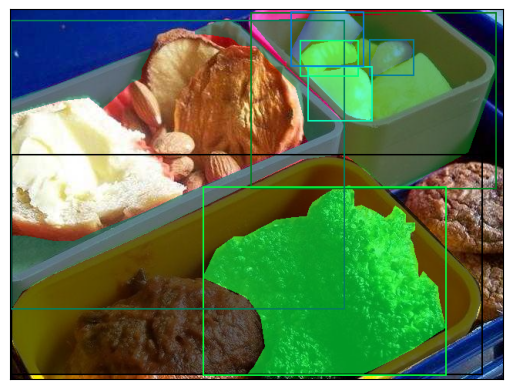

In [10]:
# visualization
train_features_batch, train_labels_batch = next(iter(training_dataloader))

image = train_features_batch[0].numpy().transpose((1, 2, 0))
ground_truth = train_labels_batch[0]['boxes']
masks = train_labels_batch[0]['masks']

# fig, ax = plt.subplots(1)
# ax.imshow(image)

# print(masks.shape)
# print(ground_truth.shape)

# for box in ground_truth:
#     rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
#         linewidth = 1, edgecolor = 'r', facecolor = 'none')
#     ax.add_patch(rect)

# plt.axis('off')
# plt.show()

image_uint8 = (train_features_batch[0] * 255).byte()
masks_bool = masks.bool()
result = draw_segmentation_masks(image_uint8, masks = masks_bool, alpha = 0.6)
result_with_boxes = draw_bounding_boxes(result, ground_truth, width = 2)

show(result_with_boxes)

#### 3. Model Construction

In [11]:
class_number_plus_background = len(training_dataset.coco.cats) + 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn_v2(weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_number_plus_background)

# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
# model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, dim_reduced, class_number_plus_background)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

learning_rate, momentum, weight_decay = 0.005, 0.9, 0.0005
step_size, gamma = 3, 0.1
unfreeze_all_layer = True

optimizer = torch.optim.SGD(params, lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

# unfrozen, set all parameters to require gradients to true
if unfreeze_all_layer:
    for param in model.parameters():
        param.requires_grad = True

print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

#### 4. Model Training

In [12]:
def plot_pr_curve(px, py, ap, save_dir = Path("pr_curve.png"), names = (), on_plot = None):
    """
    Plots a precision-recall curve.
    """
    fig, ax = plt.subplots(1, 1, figsize = (9, 6), tight_layout = True)
    py = np.stack(py, axis = 1)

    if 0 < len(names) < 21: # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth = 1, label = f"{names[i]} {ap[i, 0]:.3f}") # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth = 1, color = "grey") # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth = 3, color = "blue", label = "all classes %.3f mAP@0.5" % ap[:, 0].mean())
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    ax.set_title("Precision-Recall Curve")
    fig.savefig(save_dir, dpi = 250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)

def plot_mc_curve(px, py, save_dir = Path("mc_curve.png"), names = (), xlabel = "Confidence", ylabel = "Metric", on_plot = None):
    """
    Plots a metric-confidence curve.
    """
    fig, ax = plt.subplots(1, 1, figsize = (9, 6), tight_layout = True)

    if 0 < len(names) < 21: # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth = 1, label = f"{names[i]}") # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth = 1, color = "grey") # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth = 3, color = "blue", label = f"all classes {y.max():.2f} at {px[y.argmax()]:.3f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    ax.set_title(f"{ylabel}-Confidence Curve")
    fig.savefig(save_dir, dpi = 250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)

def box_iou(box1, box2, eps = 1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes. Both sets of boxes are expected to be in (x1, y1, x2, y2) format.

    Args:
        box1 (torch.Tensor): A tensor of shape (N, 4) representing N bounding boxes.
        box2 (torch.Tensor): A tensor of shape (M, 4) representing M bounding boxes.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): An NxM tensor containing the pairwise IoU values for every element in box1 and box2.
    """

    # inter(N, M) = (rb(N, M, 2) - lt(N, M, 2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # iou = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def mask_iou(mask1, mask2, eps = 1e-7):
    """
    Calculate masks IoU.

    Args:
        mask1 (torch.Tensor): A tensor of shape (N, n) where N is the number of ground truth objects and n is the
                        product of image width and height.
        mask2 (torch.Tensor): A tensor of shape (M, n) where M is the number of predicted objects and n is the
                        product of image width and height.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing masks IoU.
    """
    intersection = torch.matmul(mask1, mask2.T).clamp_(0)
    union = (mask1.sum(1)[:, None] + mask2.sum(1)[None]) - intersection # (area1 + area2) - intersection

    return intersection / (union + eps)

def smooth(y, f = 0.05):
    """
    Box filter of fraction f.
    """
    nf = round(len(y) * f * 2) // 2 + 1 # number of filter elements (must be odd)
    p = np.ones(nf // 2) # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0) # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode = "valid") # y-smoothed

def compute_ap(recall, precision):
    """
    Compute the average precision (AP) given the recall and precision curves.

    Args:
        recall (list): The recall curve.
        precision (list): The precision curve.

    Returns:
        (float): Average precision.
        (np.ndarray): Precision envelope curve.
        (np.ndarray): Modified recall curve with sentinel values added at the beginning and end.
    """

    # append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # integrate area under curve
    method = "interp" # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101) # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x) # integrate
    else: # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0] # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1]) # area under curve

    return ap, mpre, mrec

def ap_per_class(
    tp, conf, pred_cls, target_cls, plot = False, on_plot = None, save_dir = Path(), names = (), eps = 1e-16, prefix = ""
):
    """
    Computes the average precision per class for object detection evaluation.

    Args:
        tp (np.ndarray): Binary array indicating whether the detection is correct (True) or not (False).
        conf (np.ndarray): Array of confidence scores of the detections.
        pred_cls (np.ndarray): Array of predicted classes of the detections.
        target_cls (np.ndarray): Array of true classes of the detections.
        plot (bool, optional): Whether to plot PR curves or not. Defaults to False.
        on_plot (func, optional): A callback to pass plots path and data when they are rendered. Defaults to None.
        save_dir (Path, optional): Directory to save the PR curves. Defaults to an empty path.
        names (tuple, optional): Tuple of class names to plot PR curves. Defaults to an empty tuple.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-16.
        prefix (str, optional): A prefix string for saving the plot files. Defaults to an empty string.

    Returns:
        (tuple): A tuple of six arrays and one array of unique classes, where:
            tp (np.ndarray): True positive counts at threshold given by max F1 metric for each class.Shape: (nc,).
            fp (np.ndarray): False positive counts at threshold given by max F1 metric for each class. Shape: (nc,).
            p (np.ndarray): Precision values at threshold given by max F1 metric for each class. Shape: (nc,).
            r (np.ndarray): Recall values at threshold given by max F1 metric for each class. Shape: (nc,).
            f1 (np.ndarray): F1-score values at threshold given by max F1 metric for each class. Shape: (nc,).
            ap (np.ndarray): Average precision for each class at different IoU thresholds. Shape: (nc, 10).
            unique_classes (np.ndarray): An array of unique classes that have data. Shape: (nc,).
            p_curve (np.ndarray): Precision curves for each class. Shape: (nc, 1000).
            r_curve (np.ndarray): Recall curves for each class. Shape: (nc, 1000).
            f1_curve (np.ndarray): F1-score curves for each class. Shape: (nc, 1000).
            x (np.ndarray): X-axis values for the curves. Shape: (1000,).
            prec_values: Precision values at mAP@0.5 for each class. Shape: (nc, 1000).
    """

    # sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts = True)
    nc = unique_classes.shape[0] # number of classes, number of detections

    # create precision-recall curve and compute ap for each class
    x, prec_values = np.linspace(0, 1, 1000), []

    # average precision, precision and recall curves
    ap, p_curve, r_curve = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci] # number of labels
        n_p = i.sum() # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # accumulate fps and tps
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # recall
        recall = tpc / (n_l + eps) # recall curve
        r_curve[ci] = np.interp(-x, -conf[i], recall[:, 0], left = 0) # negative x, xp because xp decreases

        # precision
        precision = tpc / (tpc + fpc) # precision curve
        p_curve[ci] = np.interp(-x, -conf[i], precision[:, 0], left = 1) # p at pr_score

        # ap from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                prec_values.append(np.interp(x, mrec, mpre)) # precision at mAP@0.5

    prec_values = np.array(prec_values) # (nc, 1000)

    # compute f1 (harmonic mean of precision and recall)
    f1_curve = 2 * p_curve * r_curve / (p_curve + r_curve + eps)
    names = [v for k, v in names.items() if k in unique_classes] # list: only classes that have data
    names = dict(enumerate(names)) # to dict
    if plot:
        plot_pr_curve(x, prec_values, ap, save_dir / f"{prefix}PR_curve.png", names, on_plot = on_plot)
        plot_mc_curve(x, f1_curve, save_dir / f"{prefix}F1_curve.png", names, ylabel = "F1", on_plot = on_plot)
        plot_mc_curve(x, p_curve, save_dir / f"{prefix}P_curve.png", names, ylabel = "Precision", on_plot = on_plot)
        plot_mc_curve(x, r_curve, save_dir / f"{prefix}R_curve.png", names, ylabel = "Recall", on_plot = on_plot)

    i = smooth(f1_curve.mean(0), 0.1).argmax() # max f1 index
    p, r, f1 = p_curve[:, i], r_curve[:, i], f1_curve[:, i] # max-f1 precision, recall, f1 values
    tp = (r * nt).round() # true positives
    fp = (tp / (p + eps) - tp).round() # false positives
    return tp, fp, p, r, f1, ap, unique_classes.astype(int), p_curve, r_curve, f1_curve, x, prec_values

class SimpleClass:
    """
    SimpleClass is a base class providing helpful string representation, error reporting, and attribute
    access methods for easier debugging and usage.
    """

    def __str__(self):
        """
        Return a human-readable string representation of the object.
        """
        attr = []
        for a in dir(self):
            v = getattr(self, a)
            if not callable(v) and not a.startswith("_"):
                if isinstance(v, SimpleClass):
                    # display only the module and class name for subclasses
                    s = f"{a}: {v.__module__}.{v.__class__.__name__} object"
                else:
                    s = f"{a}: {repr(v)}"
                attr.append(s)
        return f"{self.__module__}.{self.__class__.__name__} object with attributes:\n\n" + "\n".join(attr)

    def __repr__(self):
        """
        Return a machine-readable string representation of the object.
        """
        return self.__str__()

    def __getattr__(self, attr):
        """
        Custom attribute access error message with helpful information.
        """
        name = self.__class__.__name__
        raise AttributeError(f"'{name}' object has no attribute '{attr}'. See valid attributes below.\n{self.__doc__}")

class Metric(SimpleClass):
    """
    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    """

    def __init__(self) -> None:
        """
        Initializes a Metric instance for computing evaluation metrics for the YOLOv8 model.
        """
        self.p = [] # (nc, )
        self.r = [] # (nc, )
        self.f1 = [] # (nc, )
        self.all_ap = [] # (nc, 10)
        self.ap_class_index = [] # (nc, )
        self.nc = 0

    @property
    def ap50(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50 values per class, or an empty list if not available.
        """
        return self.all_ap[:, 0] if len(self.all_ap) else []

    @property
    def ap(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5-0.95 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50-95 values per class, or an empty list if not available.
        """
        return self.all_ap.mean(1) if len(self.all_ap) else []

    @property
    def mp(self):
        """
        Returns the Mean Precision of all classes.

        Returns:
            (float): The mean precision of all classes.
        """
        return self.p.mean() if len(self.p) else 0.0

    @property
    def mr(self):
        """
        Returns the Mean Recall of all classes.

        Returns:
            (float): The mean recall of all classes.
        """
        return self.r.mean() if len(self.r) else 0.0

    @property
    def map50(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.5.

        Returns:
            (float): The mAP at an IoU threshold of 0.5.
        """
        return self.all_ap[:, 0].mean() if len(self.all_ap) else 0.0

    @property
    def map75(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.75.

        Returns:
            (float): The mAP at an IoU threshold of 0.75.
        """
        return self.all_ap[:, 5].mean() if len(self.all_ap) else 0.0

    @property
    def map(self):
        """
        Returns the mean Average Precision (mAP) over IoU thresholds of 0.5 - 0.95 in steps of 0.05.

        Returns:
            (float): The mAP over IoU thresholds of 0.5 - 0.95 in steps of 0.05.
        """
        return self.all_ap.mean() if len(self.all_ap) else 0.0

    def mean_results(self):
        """
        Mean of results, return mp, mr, map50, map.
        """
        return [self.mp, self.mr, self.map50, self.map]

    def class_result(self, i):
        """
        Class-aware result, return p[i], r[i], ap50[i], ap[i].
        """
        return self.p[i], self.r[i], self.ap50[i], self.ap[i]

    @property
    def maps(self):
        """
        MAP of each class.
        """
        maps = np.zeros(self.nc) + self.map
        for i, c in enumerate(self.ap_class_index):
            maps[c] = self.ap[i]
        return maps

    def fitness(self):
        """
        Model fitness as a weighted combination of metrics.
        """
        w = [0.0, 0.0, 0.1, 0.9] # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
        return (np.array(self.mean_results()) * w).sum()

    def update(self, results):
        """
        Updates the evaluation metrics of the model with a new set of results.

        Args:
            results (tuple): A tuple containing the following evaluation metrics:
                - p (list): Precision for each class. Shape: (nc,).
                - r (list): Recall for each class. Shape: (nc,).
                - f1 (list): F1 score for each class. Shape: (nc,).
                - all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
                - ap_class_index (list): Index of class for each AP score. Shape: (nc,).

        Side Effects:
            Updates the class attributes `self.p`, `self.r`, `self.f1`, `self.all_ap`, and `self.ap_class_index` based
            on the values provided in the `results` tuple.
        """
        (
            self.p,
            self.r,
            self.f1,
            self.all_ap,
            self.ap_class_index,
            self.p_curve,
            self.r_curve,
            self.f1_curve,
            self.px,
            self.prec_values,
        ) = results

    @property
    def curves(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return []

    @property
    def curves_results(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return [
            [self.px, self.prec_values, "Recall", "Precision"],
            [self.px, self.f1_curve, "Confidence", "F1"],
            [self.px, self.p_curve, "Confidence", "Precision"],
            [self.px, self.r_curve, "Confidence", "Recall"],
        ]

class SegmentMetrics(SimpleClass):
    """
    Calculates and aggregates detection and segmentation metrics over a given set of classes.

    Args:
        save_dir (Path): Path to the directory where the output plots should be saved. Default is the current directory.
        plot (bool): Whether to save the detection and segmentation plots. Default is False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (list): List of class names. Default is an empty list.

    Attributes:
        save_dir (Path): Path to the directory where the output plots should be saved.
        plot (bool): Whether to save the detection and segmentation plots.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (list): List of class names.
        box (Metric): An instance of the Metric class to calculate box detection metrics.
        seg (Metric): An instance of the Metric class to calculate mask segmentation metrics.
        speed (dict): Dictionary to store the time taken in different phases of inference.

    Methods:
        process(tp_m, tp_b, conf, pred_cls, target_cls): Processes metrics over the given set of predictions.
        mean_results(): Returns the mean of the detection and segmentation metrics over all the classes.
        class_result(i): Returns the detection and segmentation metrics of class `i`.
        maps: Returns the mean Average Precision (mAP) scores for IoU thresholds ranging from 0.50 to 0.95.
        fitness: Returns the fitness scores, which are a single weighted combination of metrics.
        ap_class_index: Returns the list of indices of classes used to compute Average Precision (AP).
        results_dict: Returns the dictionary containing all the detection and segmentation metrics and fitness score.
    """

    def __init__(self, save_dir = Path("."), plot = False, on_plot = None, names = ()) -> None:
        """
        Initialize a SegmentMetrics instance with a save directory, plot flag, callback function, and class names.
        """
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.seg = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "segment"

    def process(self, tp, tp_m, conf, pred_cls, target_cls):
        """
        Processes the detection and segmentation metrics over the given set of predictions.

        Args:
            tp (list): List of True Positive boxes.
            tp_m (list): List of True Positive masks.
            conf (list): List of confidence scores.
            pred_cls (list): List of predicted classes.
            target_cls (list): List of target classes.
        """

        results_mask = ap_per_class(
            tp_m,
            conf,
            pred_cls,
            target_cls,
            plot = self.plot,
            on_plot = self.on_plot,
            save_dir = self.save_dir,
            names = self.names,
            prefix = "Mask",
        )[2:]
        self.seg.nc = len(self.names)
        self.seg.update(results_mask)
        results_box = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot = self.plot,
            on_plot = self.on_plot,
            save_dir = self.save_dir,
            names = self.names,
            prefix = "Box",
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results_box)

    @property
    def keys(self):
        """
        Returns a list of keys for accessing metrics.
        """
        return [
            "metrics/precision(B)",
            "metrics/recall(B)",
            "metrics/mAP50(B)",
            "metrics/mAP50-95(B)",
            "metrics/precision(M)",
            "metrics/recall(M)",
            "metrics/mAP50(M)",
            "metrics/mAP50-95(M)",
        ]

    def mean_results(self):
        """
        Return the mean metrics for bounding box and segmentation results.
        """
        return self.box.mean_results() + self.seg.mean_results()

    def class_result(self, i):
        """
        Returns classification results for a specified class index.
        """
        return self.box.class_result(i) + self.seg.class_result(i)

    @property
    def maps(self):
        """
        Returns mAP scores for object detection and semantic segmentation models.
        """
        return self.box.maps + self.seg.maps

    @property
    def fitness(self):
        """
        Get the fitness score for both segmentation and bounding box models.
        """
        return self.seg.fitness() + self.box.fitness()

    @property
    def ap_class_index(self):
        """
        Boxes and masks have the same ap_class_index.
        """
        return self.box.ap_class_index

    @property
    def results_dict(self):
        """
        Returns results of object detection model for evaluation.
        """
        return dict(zip(self.keys + ["fitness"], self.mean_results() + [self.fitness]))

    @property
    def curves(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return [
            "Precision-Recall(B)",
            "F1-Confidence(B)",
            "Precision-Confidence(B)",
            "Recall-Confidence(B)",
            "Precision-Recall(M)",
            "F1-Confidence(M)",
            "Precision-Confidence(M)",
            "Recall-Confidence(M)",
        ]

    @property
    def curves_results(self):
        """
        Returns dictionary of computed performance metrics and statistics.
        """
        return self.box.curves_results + self.seg.curves_results

def match_prediction(pred_classes, true_classes, iou, iouv, use_scipy = False):
    """
    Matches predictions to ground truth objects (pred_classes, true_classes) using IoU.

    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape(N,).
        true_classes (torch.Tensor): Target class indices of shape(M,).
        iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground of truth
        use_scipy (bool): Whether to use scipy for matching (more precise).

    Returns:
        (torch.Tensor): Correct tensor of shape(N,10) for 10 IoU thresholds.
    """
    # Dx10 matrix, where D - detections, 10 - IoU thresholds
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
    # LxD matrix where L - labels (rows), D - detections (columns)
    correct_class = true_classes[:, None] == pred_classes
    iou = iou * correct_class # zero out the wrong classes
    iou = iou.cpu().numpy()

    for i, threshold in enumerate(iouv.cpu().tolist()):
        if use_scipy:
            import scipy # scope import to avoid importing for all commands

            cost_matrix = iou * (iou >= threshold)

            if cost_matrix.any():
                labels_idx, detections_idx = scipy.optimize.linear_sum_assignment(cost_matrix, maximize = True)
                valid = cost_matrix[labels_idx, detections_idx] > 0

                if valid.any():
                    correct[detections_idx[valid], i] = True
        else:
            matches = np.nonzero(iou >= threshold) # iou > threshold and classes match
            matches = np.array(matches).T

            if matches.shape[0]:
                if matches.shape[0] > 1:
                    matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 1], return_index = True)[1]]
                    # matches = matches[matches[:, 2].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 0], return_index = True)[1]]
                correct[matches[:, 1].astype(int), i] = True

    return torch.tensor(correct, dtype = torch.bool, device = pred_classes.device)

def process_batch(pred_box, pred_label, gt_bboxes, gt_cls, iouv, pred_masks = None, gt_masks = None, overlap = False, masks = False):
    """
    Return correct prediction matrix.

    Args:
        detections (array[N, 6]), x1, y1, x2, y2, conf, class
        labels (array[M, 5]), class, x1, y1, x2, y2

    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    if masks:
        pred_masks = pred_masks.squeeze(1)
        # initialize the combined mask with zero
        combined_mask = np.zeros(gt_masks.shape[1:], dtype = np.uint8)
        # iterate over each instance mask
        for mask in gt_masks:
            # where the instance mask has a value, mark it in the combined mask
            combined_mask = np.maximum(combined_mask, mask)
        # ensure the combined mask is in the desired shape (1, height, width)
        gt_masks = combined_mask[np.newaxis, ...]

        if overlap:
            nl = len(gt_cls)
            index = torch.arange(nl, device = gt_masks.device).view(nl, 1, 1) + 1
            gt_masks = gt_masks.repeat(nl, 1, 1) # shape(1, 640, 640) -> (n, 640, 640)
            gt_masks = torch.where(gt_masks == index, 1.0, 0.0)
        if gt_masks.shape[1:] != pred_masks.shape[1:]:
            gt_masks = tnnf.interpolate(gt_masks[None], pred_masks.shape[1:], mode = "bilinear", align_corners = False)[0]
            gt_masks = gt_masks.gt_(0.5)
        iou = mask_iou(gt_masks.view(gt_masks.shape[0], -1), pred_masks.view(pred_masks.shape[0], -1))
    else: # boxes
        iou = box_iou(gt_bboxes, pred_box)

    return match_prediction(pred_label, gt_cls, iou, iouv)

def evaluation_loss_map(model, validation_dataset, validation_dataloader,
    selected_keys, device, iou_types, cpu_device, names):
    model.eval()

    val_loss = 0.0
    val_loss_classifier = 0.0
    val_loss_box_reg = 0.0
    val_loss_mask = 0.0
    val_loss_objectness = 0.0
    val_loss_rpn_box_reg = 0.0

    coco = validation_dataloader.dataset.coco
    nc = len(names)

    with torch.inference_mode():
        coco_gt = copy.deepcopy(coco)
        coco_eval = {}
        img_ids_list = []
        eval_imgs_list = {k: [] for k in iou_types}
        stats = dict(tp_m = [], tp = [], conf = [], pred_cls = [], target_cls = [], target_img = [])
        iouv = torch.linspace(0.5, 0.95, 10) # iou vector for map@0.5:0.95
        niou = iouv.numel()

        for iou_type in iou_types:
            coco_eval[iou_type] = COCOeval(coco_gt, iouType = iou_type)

        for batch_idx, (images, targets) in enumerate(validation_dataloader):
            images = list(image.to(device) for image in images)
            eval_targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

            losses, detections = evaluation_forward(model, images, eval_targets)
            loss = sum(loss for loss in losses.values())

            val_loss += loss.item()
            val_loss_classifier += losses["loss_classifier"].item()
            val_loss_box_reg += losses["loss_box_reg"].item()
            val_loss_mask += losses["loss_mask"].item()
            val_loss_objectness += losses["loss_objectness"].item()
            val_loss_rpn_box_reg += losses["loss_rpn_box_reg"].item()

            if torch.cuda.is_available():
                torch.cuda.synchronize()

            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            for index, output in enumerate(zip(outputs, targets)):
                pred_box = output[0]['boxes']
                pred_label = output[0]['labels']
                pred_score = output[0]['scores']
                pred_mask = output[0]['masks']

                # update stats and metric
                npr = len(pred_label)
                stat = dict(
                    conf = torch.zeros(0, device = cpu_device),
                    pred_cls = torch.zeros(0, device = cpu_device),
                    tp = torch.zeros(npr, niou, dtype = torch.bool, device = cpu_device),
                    tp_m = torch.zeros(npr, niou, dtype = torch.bool, device = cpu_device),
                )

                cls, bbox = output[1]["labels"], output[1]["boxes"]
                nl = len(cls)
                stat["target_cls"] = cls
                stat["target_img"] = cls.unique()

                if npr == 0:
                    if nl:
                        for k in stats.keys():
                            stats[k].append(stat[k])
                    continue

                # mask
                gt_masks = output[1]["masks"]

                # prediction
                stat["conf"] = pred_score
                stat["pred_cls"] = pred_label

                if nl:
                    stat["tp"] = process_batch(pred_box, pred_label, bbox, cls, iouv)
                    stat["tp_m"] = process_batch(
                        pred_box, pred_label, bbox, cls, iouv, pred_mask, gt_masks, overlap = True, masks = True
                    )

                for k in stats.keys():
                    stats[k].append(stat[k])

            # coco evaluation
            res = {target["image_id"]: output for target, output in zip(targets, outputs)}

            unique_img_ids = list(np.unique(list(res.keys())))
            img_ids_list.extend(unique_img_ids)

            for iou_type in iou_types:
                if iou_type == "bbox":
                    results = prepare_for_coco_detection(res)
                if iou_type == 'segm':
                    results = prepare_for_coco_segmentation(res)
                with redirect_stdout(io.StringIO()):
                    coco_dt = COCO.loadRes(coco_gt, results) if results else COCO()

                eval = coco_eval[iou_type]

                eval.cocoDt = coco_dt
                eval.params.imgIds = list(unique_img_ids)

                img_ids, eval_imgs = coco_evaluate(eval)

                eval_imgs_list[iou_type].append(eval_imgs)

            # delete tensor and clear cache to free up memory
            del images, eval_targets, targets, losses, detections
            # clear system memory
            gc.collect()

        # clear cache after each epoch
        torch.cuda.empty_cache()
        # clear system memory
        gc.collect()

        # validation loss data
        losses_dict = {
            'total_val_loss': val_loss / len(validation_dataloader),
            'total_val_loss_classifier': val_loss_classifier / len(validation_dataloader),
            'total_val_loss_box_reg': val_loss_box_reg / len(validation_dataloader),
            'total_val_loss_mask': val_loss_mask / len(validation_dataloader),
            'total_val_loss_objectness': val_loss_objectness / len(validation_dataloader),
            'total_val_loss_rpn_box_reg': val_loss_rpn_box_reg / len(validation_dataloader)
        }

        # to numpy
        stats = {k: torch.cat(v, 0).cpu().numpy() for k, v in stats.items()}
        nt_per_class = np.bincount(stats["target_cls"].astype(int), minlength = nc)
        nt_per_image = np.bincount(stats["target_img"].astype(int), minlength = nc)
        stats.pop("target_img", None)

        seg_metrics = SegmentMetrics(names = names)

        if len(stats) and stats["tp"].any():
            seg_metrics.process(**stats)

        custom_seg_metrics = seg_metrics.results_dict
        custom_seg_metrics = {k: round(float(v), 5) for k, v in custom_seg_metrics.items()}

        mean_results = seg_metrics.mean_results()

        # synchronize between processes
        for iou_type in iou_types:
            eval_imgs_list[iou_type] = np.concatenate(eval_imgs_list[iou_type], 2)

            array_img_ids = np.array(img_ids_list)
            merged_img_ids, idx = np.unique(array_img_ids, return_index = True)
            merged_eval_imgs = eval_imgs_list[iou_type][..., idx]

            img_ids = list(merged_img_ids)
            eval_imgs = list(merged_eval_imgs.flatten())

            coco_eval[iou_type].evalImgs = eval_imgs
            coco_eval[iou_type].params.imgIds = img_ids
            coco_eval[iou_type]._paramsEval = copy.deepcopy(coco_eval[iou_type].params)

        # coco accumulate
        for eval in coco_eval.values():
            eval.accumulate()

        # coco summary
        for iou_type, eval in coco_eval.items():
            print(f"IoU metric: {iou_type}")
            eval.summarize()

    return losses_dict, custom_seg_metrics

In [13]:
pip_requirements = [
    'torch==2.1.2+cu118',
    'torchvision==0.16.2+cu118'
]
conda_env = {
    'name': 'mlflow-env',
    'channels': ['conda-forge'],
    'dependencies': [
        'python=3.11.9',
        'pip<=23.3.1',
        {'pip': ['mlflow==2.12.1', 'torch==2.1.2+cu118', 'cloudpickle==3.0.0']}
    ]
}

# auto log all entities
mlflow.pytorch.autolog(disable = False)

# with mlflow.start_run(tags = {"Version": 1}) as run:
with mlflow.start_run() as run:
    # log user and model detail
    mlflow.set_tag("developer", "christopher")
    mlflow.set_tag("model", "mask_rcnn_resnet50_fpn_v2")
    mlflow.set_tag("version", mlflow.__version__)

    # log training path
    mlflow.log_param("train-data-path", training_dataset.root)
    mlflow.log_param("valid-data-path", validation_dataset.root)
    mlflow.log_param("train-annotation-path", training_dataset.annFile)
    mlflow.log_param("valid-annotation-path", validation_dataset.annFile)

    # log optimizer parameter
    mlflow.log_param("optimizer", type(optimizer).__name__)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("weight_decay", weight_decay)

    # log scheduler parameter
    mlflow.log_param("scheduler", type(lr_scheduler).__name__)
    mlflow.log_param("step_size", step_size)
    mlflow.log_param("gamma", gamma)

    # freeze/ unfreeze all layers
    mlflow.log_param("unfreeze_all_layer", unfreeze_all_layer)

    num_epochs = 10
    selected_keys = ['boxes', 'labels', 'masks']
    iou_types = get_iou_types(model)
    cpu_device = torch.device("cpu")

    result = {
        "total_train_loss": [],
        "total_val_loss": [],
        "total_train_loss_classifier": [],
        "total_val_loss_classifier": [],
        "total_train_loss_box_reg": [],
        "total_val_loss_box_reg": [],
        "total_train_loss_mask": [],
        "total_val_loss_mask": [],
        "total_train_loss_objectness": [],
        "total_val_loss_objectness": [],
        "total_train_loss_rpn_box_reg": [],
        "total_val_loss_rpn_box_reg": []
    }

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        train_loss_classifier = 0.0
        train_loss_box_reg = 0.0
        train_loss_mask = 0.0
        train_loss_objectness = 0.0
        train_loss_rpn_box_reg = 0.0

        for batch_idx, (images, targets) in enumerate(training_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

            # forward pass
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loss_classifier += loss_dict["loss_classifier"].item()
            train_loss_box_reg += loss_dict["loss_box_reg"].item()
            train_loss_mask += loss_dict["loss_mask"].item()
            train_loss_objectness += loss_dict["loss_objectness"].item()
            train_loss_rpn_box_reg += loss_dict["loss_rpn_box_reg"].item()

            # delete tensor and clear cache to free up memory
            del images, targets, loss_dict
            # clear system memory
            gc.collect()

        val_loss_result = evaluation_loss_map(model, validation_dataset, validation_dataloader, 
            selected_keys, device, iou_types, cpu_device, catId_to_name_validation)

        print(val_loss_result[1])

        # clear cache after each epoch
        torch.cuda.empty_cache()
        # clear system memory
        gc.collect()

        # print total train loss per epoch
        total_train_loss = train_loss / len(training_dataloader)
        total_train_loss_classifier = train_loss_classifier / len(training_dataloader)
        total_train_loss_box_reg = train_loss_box_reg / len(training_dataloader)
        total_train_loss_mask = train_loss_mask / len(training_dataloader)
        total_train_loss_objectness = train_loss_objectness / len(training_dataloader)
        total_train_loss_rpn_box_reg = train_loss_rpn_box_reg / len(training_dataloader)

        # log training loss
        mlflow.log_metric("total_train_loss", total_train_loss, step = epoch)
        mlflow.log_metric("train_loss_classifier", total_train_loss_classifier, step = epoch)
        mlflow.log_metric("train_loss_box_reg", total_train_loss_box_reg, step = epoch)
        mlflow.log_metric("train_loss_mask", total_train_loss_mask, step = epoch)
        mlflow.log_metric("train_loss_objectness", total_train_loss_objectness, step = epoch)
        mlflow.log_metric("train_loss_rpn_box_reg", total_train_loss_rpn_box_reg, step = epoch)

        # log validation loss
        mlflow.log_metric("total_val_loss", val_loss_result[0]["total_val_loss"], step = epoch)
        mlflow.log_metric("val_loss_classifier", val_loss_result[0]["total_val_loss_classifier"], step = epoch)
        mlflow.log_metric("val_loss_box_reg", val_loss_result[0]["total_val_loss_box_reg"], step = epoch)
        mlflow.log_metric("val_loss_mask", val_loss_result[0]["total_val_loss_mask"], step = epoch)
        mlflow.log_metric("val_loss_objectness", val_loss_result[0]["total_val_loss_objectness"], step = epoch)
        mlflow.log_metric("val_loss_rpn_box_reg", val_loss_result[0]["total_val_loss_rpn_box_reg"], step = epoch)

        result["total_train_loss"].append(total_train_loss)
        result["total_train_loss_classifier"].append(total_train_loss_classifier)
        result["total_train_loss_box_reg"].append(total_train_loss_box_reg)
        result["total_train_loss_mask"].append(total_train_loss_mask)
        result["total_train_loss_objectness"].append(total_train_loss_objectness)
        result["total_train_loss_rpn_box_reg"].append(total_train_loss_rpn_box_reg)

        result["total_val_loss"].append(val_loss_result[0]["total_val_loss"])
        result["total_val_loss_classifier"].append(val_loss_result[0]["total_val_loss_classifier"])
        result["total_val_loss_box_reg"].append(val_loss_result[0]["total_val_loss_box_reg"])
        result["total_val_loss_mask"].append(val_loss_result[0]["total_val_loss_mask"])
        result["total_val_loss_objectness"].append(val_loss_result[0]["total_val_loss_objectness"])
        result["total_val_loss_rpn_box_reg"].append(val_loss_result[0]["total_val_loss_rpn_box_reg"])

        # log model to artifact as a checkpoint
        base_dir = "model_checkpoint"
        checkpoint_path = f"{base_dir}/epoch_{epoch + 1}"
        mlflow.pytorch.log_model(model, checkpoint_path, pip_requirements = pip_requirements)

        print(f'Epoch {epoch + 1}, Loss: {total_train_loss}')
        print(f'Max allocated memory: {torch.cuda.max_memory_allocated(device) / 1024 ** 2} MB, Allocated memory: {torch.cuda.memory_allocated(device) / 1024 ** 2} MB')
        print(f'Max reserved memory: {torch.cuda.max_memory_reserved(device) / 1024 ** 2} MB, Reserved memory: {torch.cuda.memory_reserved(device) / 1024 ** 2} MB')
        print("")

    # specify path
    model_path = "model"
    scripted_model_path = "scripted_model"

    # delete the directories if they exist
    for path in [model_path, scripted_model_path]:
        shutil.rmtree(path, ignore_errors = True)

    # log/ save the model to artifact/ local
    mlflow.pytorch.log_model(model, model_path, pip_requirements = pip_requirements)
    mlflow.pytorch.save_model(model, model_path, pip_requirements = pip_requirements)

    # convert to scripted model and log/ save the model to artifact/ local
    scripted_model = torch.jit.script(model)
    mlflow.pytorch.log_model(scripted_model, scripted_model_path, pip_requirements = pip_requirements)
    mlflow.pytorch.save_model(scripted_model, scripted_model_path, pip_requirements = pip_requirements)

    # # save transform locally
    # with open('model/transform.bin', 'wb') as f_out:
    #     pickle.dump((transform), f_out)

    # # log artifact for model
    # mlflow.log_artifact(local_path = "model/transform.bin", artifact_path = "transform_pickle")

    now = datetime.now()
    dir_name = now.strftime("%Y-%m-%d_%H-%M-%S")
    save_loss_curve(result, dir_name)

    # log artifact for loss curve
    mlflow.log_artifact(f"result/{dir_name}/loss_plot.png", artifact_path = "loss_plot")

# get the auto logged parameters and metric
print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

# default conda environment
env = mlflow.pytorch.get_default_conda_env()
print(f"conda env: {env}")

2024/06/14 16:17:43 DEBUG mlflow.utils.autologging_utils: Called autolog() method for pytorch autologging with args '()' and kwargs '{'log_every_n_epoch': 1, 'log_every_n_step': None, 'log_models': True, 'log_datasets': True, 'disable': False, 'exclusive': False, 'disable_for_unsupported_versions': False, 'silent': False, 'registered_model_name': None, 'extra_tags': None, 'checkpoint': True, 'checkpoint_monitor': 'val_loss', 'checkpoint_mode': 'min', 'checkpoint_save_best_only': True, 'checkpoint_save_weights_only': False, 'checkpoint_save_freq': 'epoch'}'
2024/06/14 16:17:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/06/14 16:17:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 

#### 5. Inference

device: cuda:0, training: False


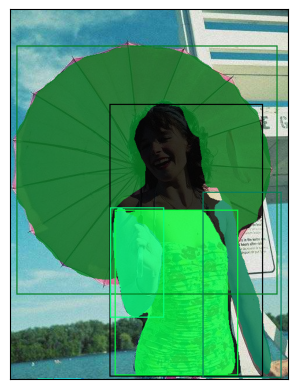

In [ ]:
cpu_device = torch.device("cpu")

# load model from Mlflow artifact
run_id = run.info.run_id
model_path = f"runs:/{run_id}/model"
loaded_model = mlflow.pytorch.load_model(model_path)

# check models` device
print(f"device: {next(loaded_model.parameters()).device}, training: {loaded_model.training}")

resize_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.Resize((640, 640), antialias = True),
    v2.ToDtype(torch.float32, scale = True),
])

image_path = "../../../dataset/coco8-seg/valid/images/000000000036_jpg.rf.6783d468f8475090f3d3f214930df8aa.jpg"

ori_img = Image.open(image_path)
ori_img = transform(ori_img).unsqueeze(0).to(device)

image = Image.open(image_path)
image = resize_transform(image).unsqueeze(0).to(device)

# model.eval()

with torch.no_grad():
# with torch.inference_mode():
    output = loaded_model(image)
    masks = output[0]['masks'].squeeze(1).to(cpu_device)
    
    # total_mask = masks.sum(axis = 0)
    # total_mask = total_mask / total_mask.max()

    ori_height, ori_width = ori_img.squeeze(0).shape[1], ori_img.squeeze(0).shape[2]
    cur_height, cur_width = image.squeeze(0).shape[1], image.squeeze(0).shape[2]

    resized_masks = torch.empty((len(masks), ori_height, ori_width))

    for i, mask in enumerate(masks):
        masks_pil = Image.fromarray(mask.numpy())
        masks_resized = F.resize(masks_pil, [ori_height, ori_width])
        masks_resized_tensor = torch.from_numpy(np.array(masks_resized))
        resized_masks[i] = masks_resized_tensor

    masks_tensor_bool = resized_masks > 0.5

    boxes = output[0]['boxes'].to(cpu_device)
    width_scale = ori_width / cur_width
    height_scale = ori_height / cur_height

    scaled_boxes = []

    for box in boxes:
        scaled_box = [
            box[0] * width_scale, 
            box[1] * height_scale, 
            box[2] * width_scale, 
            box[3] * height_scale
        ]
        scaled_boxes.append(scaled_box)

    scaled_boxes_tensor = torch.tensor(scaled_boxes)

    scores = output[0]['scores'].to(cpu_device)

    keep = nms(boxes, scores, iou_threshold = 0.5)
    scaled_boxes_tensor = scaled_boxes_tensor[keep]
    masks_tensor_bool = masks_tensor_bool[keep]

    image_uint8 = (ori_img.squeeze(0) * 255).to(torch.uint8)
    result = draw_segmentation_masks(image_uint8, masks = masks_tensor_bool, alpha = 0.8)
    # colors = ['red'] * len(scaled_boxes_tensor)
    # result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 5, colors = colors)
    result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 2)

    show(result_with_boxes)

#### 6. Model Register

In [14]:
# function to retrieve experiment id based on experiment name
def get_experiment_id(client, name):
    experiments = client.search_experiments()
    for exp in experiments:
        if exp.name == name:
            return exp.experiment_id

# get experiment id
client = MlflowClient(tracking_uri = mlflow_tracking_url)
experiment_id = get_experiment_id(client, experiment_name)

print(f"the experiement id is: {experiment_id}")

the experiement id is: 1


In [15]:
# search for the top 3 lowest training loss
top_3_lowest_training_loss = client.search_runs(
    experiment_ids = experiment_id,
    filter_string = "metrics.total_train_loss < 0.4 and tags.model = 'mask_rcnn_resnet50_fpn_v2' and attributes.status = 'FINISHED'",
    run_view_type = ViewType.ACTIVE_ONLY,
    max_results = 3,
    order_by = ["metrics.total_train_loss ASC"]
)

# print(top_3_lowest_training_loss)

for tl in top_3_lowest_training_loss:
    print(f"run id: {tl.info.run_id}, total_train_loss: {tl.data.metrics['total_train_loss']:.4f}")

# df = pd.DataFrame({
#     'run_id': [run.info.run_id for run in top_3_lowest_training_loss],
#     'experiment_id': [run.info.experiment_id for run in top_3_lowest_training_loss],
#     'status': [run.info.status for run in top_3_lowest_training_loss],
#     'total_train_loss': [run.data.metrics['total_train_loss'] for run in top_3_lowest_training_loss]
# })

# get the first run id that has the most lowest training loss
run_id = top_3_lowest_training_loss[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model_register_name = "coco8-inst-detection"

registered_model = [rm.name for rm in client.search_registered_models()]

if model_register_name in registered_model:
    print(f"Model {model_register_name} is registered.")
else:
    client.create_registered_model("coco8-inst-detection")

# register the model
client.create_model_version(
    name = model_register_name,
    source = model_uri, 
    run_id = run_id
)

# register the model directly to 'Staging'
# model_detail = client.create_model_version(
#     name = model_register_name,
#     source = model_uri, 
#     run_id = run_id
# )

# client.transition_model_version_stage(
#     name = "coco8-inst-detection",
#     version = model_detail.version,
#     stage = "Staging",
# )

run id: 7923d558c80741939aaa7f5bb4bbac44, total_train_loss: 0.2571
run id: 664dd79aec094748a663bf852153705d, total_train_loss: 0.2907
run id: 0a176bbf29954e6093222d32872bd255, total_train_loss: 0.2928
Model coco8-inst-detection is registered.


<ModelVersion: aliases=[], creation_timestamp=1717660829593, current_stage='None', description=None, last_updated_timestamp=1717660829593, name='coco8-inst-detection', run_id='7923d558c80741939aaa7f5bb4bbac44', run_link=None, source='runs:/7923d558c80741939aaa7f5bb4bbac44/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [16]:
model_version = 1
new_stage = "Staging"
date = datetime.today().date()

# transition the model version to the "Staging" stage
client.transition_model_version_stage(
    name = model_register_name,
    version = model_version,
    stage = new_stage,
    archive_existing_versions = False
)

# update the model version description
client.update_model_version(
    name = model_register_name,
    version = model_version,
    description = f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_24804\2642757743.py:6: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1717652547654, current_stage='Staging', description='The model version 1 was transitioned to Staging on 2024-06-06', last_updated_timestamp=1717660829630, name='coco8-inst-detection', run_id='7923d558c80741939aaa7f5bb4bbac44', run_link=None, source='runs:/7923d558c80741939aaa7f5bb4bbac44/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [18]:
new_stage = "Production"
date = datetime.today().date()

# transition the model version to the "Production" stage
client.transition_model_version_stage(
    name = "coco8-inst-detection",
    version = model_version,
    stage = new_stage,
    archive_existing_versions = True
)

# update the model version description
client.update_model_version(
    name = model_register_name,
    version = model_version,
    description = f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_9072\940611792.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1717652547654, current_stage='Production', description='The model version 1 was transitioned to Production on 2024-06-06', last_updated_timestamp=1717656273470, name='coco8-inst-detection', run_id='7923d558c80741939aaa7f5bb4bbac44', run_link=None, source='runs:/7923d558c80741939aaa7f5bb4bbac44/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [23]:
# find registered model in 'Production' stage
stage = "Production"
mlflow.set_tracking_uri(mlflow_tracking_url)

model = mlflow.pyfunc.load_model(model_uri = f"models:/{model_register_name}/{stage}")
model

c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.pytorch
  run_id: 7923d558c80741939aaa7f5bb4bbac44